In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/aaiteam4/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import numpy as np

# Download necessary NLTK data (run this once)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
# 1. Get the dataset from Hugging Face
dataset_name = "cnamuangtoun/resume-job-description-fit"
try:
    dataset = load_dataset(dataset_name)
    df = dataset['train'].to_pandas()
    print(f"Dataset '{dataset_name}' loaded successfully. Shape: {df.shape}")
    print("Column names in the DataFrame:")
    print(df.columns)
    # We need to identify the correct column names for text and labels
    TEXT_COLUMN = None  # We will update this based on the output
    LABEL_COLUMN = None # We will update this based on the output
except Exception as e:
    print(f"Error loading dataset '{dataset_name}': {e}")
    exit()

Dataset 'cnamuangtoun/resume-job-description-fit' loaded successfully. Shape: (6241, 3)
Column names in the DataFrame:
Index(['resume_text', 'job_description_text', 'label'], dtype='object')


In [7]:
# 2. Preprocessing
TEXT_COLUMN_RESUME = 'resume_text'
TEXT_COLUMN_JOB = 'job_description_text'
LABEL_COLUMN = 'label'

stop_words = set(stopwords.words('english'))
custom_stopwords = ['e.g.', 'i.e.', 'etc.', 'the', 'and', 'a', 'an', 'in', 'of', 'to'] # Add more if needed
stop_words.update(custom_stopwords)

def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        # Remove non-ASCII characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove numbers (keeping those with % $ or year format)
        text = re.sub(r'(?<!\d)(?<![\$\%])\b\d+\b', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove stopwords
        text_tokens = text.split()
        filtered_tokens = [w for w in text_tokens if not w in stop_words]
        return " ".join(filtered_tokens)
    return ""

print("Applying preprocessing...")
df['processed_resume'] = df[TEXT_COLUMN_RESUME].apply(preprocess_text)
df['processed_job_description'] = df[TEXT_COLUMN_JOB].apply(preprocess_text)
# Combine processed resume and job description for the model
df['combined_text'] = df['processed_resume'] + ' ' + df['processed_job_description']
df = df[df['combined_text'].str.len() > 0] # Remove rows with empty combined text
print("Preprocessing complete.")

# Encode the categorical labels to numerical values
label_mapping = {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
df['label_encoded'] = df[LABEL_COLUMN].map(label_mapping)
print(f"Unique labels and their encoding: {label_mapping}")
print(f"Encoded labels: {df['label_encoded'].unique()}")


Applying preprocessing...
Preprocessing complete.
Unique labels and their encoding: {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
Encoded labels: [0 1 2]


In [8]:
# 3. Sentence-BERT Embedding
model_name = 'all-mpnet-base-v2'
try:
    model = SentenceTransformer(model_name)
    print(f"Sentence-BERT model '{model_name}' loaded.")
    embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=True)
    embeddings_df = pd.DataFrame(embeddings)
    df = pd.concat([df.reset_index(drop=True), embeddings_df], axis=1)
    print("Sentence embeddings generated.")
except Exception as e:
    print(f"Error loading or using Sentence-BERT model '{model_name}': {e}")
    exit()

# Prepare data for the Naive Bayes model
X = df.iloc[:, -768:] # Assuming embeddings are the last 768 columns
y = df['label_encoded']

Sentence-BERT model 'all-mpnet-base-v2' loaded.


Batches:   0%|          | 0/196 [00:00<?, ?it/s]

Sentence embeddings generated.


In [9]:
def calculate_similarity(row):
    resume_embedding = row.iloc[-768:]  # Get the resume embedding
    job_embedding = model.encode(row['processed_job_description']) # Encode job description
    return cosine_similarity([resume_embedding], [job_embedding])[0][0]

print("Calculating cosine similarity between resume and job description...")
df['similarity_score'] = df.apply(calculate_similarity, axis=1)
print("Cosine similarity calculated.")

# Now, let's look at the distribution of similarity scores for each class
print("\nAverage similarity score per class:")
print(df.groupby('label_encoded')['similarity_score'].mean())

# Prepare data with the similarity score as a feature
X_with_similarity = pd.concat([df.iloc[:, -769:-1], df['similarity_score']], axis=1) # Embeddings + similarity
y = df['label_encoded']

Calculating cosine similarity between resume and job description...
Cosine similarity calculated.

Average similarity score per class:
label_encoded
0    0.550505
1    0.600906
2    0.630188
Name: similarity_score, dtype: float64


In [10]:
# Convert all column names to strings
X_with_similarity.columns = X_with_similarity.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X_with_similarity, y, test_size=0.2, random_state=42)

print(f"Original class distribution: {Counter(y)}")

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training class distribution: {Counter(y_resampled)}")

Original class distribution: Counter({0: 3143, 1: 1556, 2: 1542})
Resampled training class distribution: Counter({1: 2485, 0: 2485, 2: 2485})


In [11]:
# 4. Train Naive Bayes (NB) model
# Define the parameter grid
param_grid_nb = {'var_smoothing': np.logspace(0, -9, num=100)}

# Initialize GridSearchCV
grid_search_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='f1_macro', n_jobs=-1)

print("\nPerforming hyperparameter tuning for Naive Bayes...")
grid_search_nb.fit(X_resampled, y_resampled) # Use the resampled training data

print("Best hyperparameters for Naive Bayes:", grid_search_nb.best_params_)
print("Best macro F1-score on the resampled training data:", grid_search_nb.best_score_)

# Evaluate the best model on the original test set
best_nb_model = grid_search_nb.best_estimator_
y_pred_tuned_nb = best_nb_model.predict(X_test)


print("\nClassification Report of Naive Bayes model trained with similarity feature + SBERT Embeddings:")
print(classification_report(y_test, y_pred_tuned_nb, zero_division=0))

print("\nEvaluation complete of Naive Bayes model trained with similarity feature.")


Performing hyperparameter tuning for Naive Bayes...
Best hyperparameters for Naive Bayes: {'var_smoothing': 3.511191734215127e-05}
Best macro F1-score on the resampled training data: 0.4165712800920267

Classification Report of Naive Bayes model trained with similarity feature + SBERT Embeddings:
              precision    recall  f1-score   support

           0       0.59      0.33      0.43       658
           1       0.26      0.34      0.29       288
           2       0.27      0.45      0.34       303

    accuracy                           0.36      1249
   macro avg       0.37      0.37      0.35      1249
weighted avg       0.44      0.36      0.38      1249


Evaluation complete of Naive Bayes model trained with similarity feature.


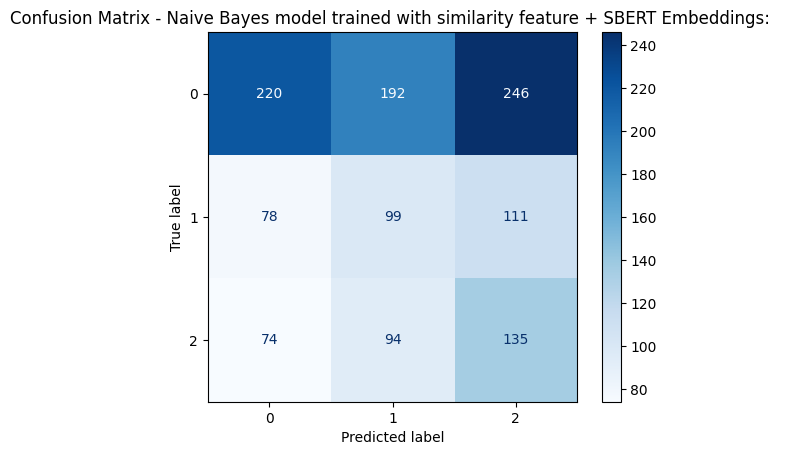

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned_nb,)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_nb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes model trained with similarity feature + SBERT Embeddings: ")
plt.show()


In [ ]:

def compute_similarity_scores(resume_embed, jd_embed):
    similarities = cosine_similarity([resume_embedding], [job_embedding])
    return similarities[0, 0]  # each resume vs its own JD



similarity_scores = [
    compute_similarity_scores(X_resume_test[i], X_job_test[i])
    for i in range(X_resume_test.shape[0])
]


mean_similarity = np.mean(similarity_scores)
std_dev_similarity = np.std(similarity_scores)
threshold = mean_similarity + 1 * std_dev_similarity

#xgb_labels = xgb_predictions.map(inverse_label_mapping)
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
xgb_labels = [inverse_label_mapping[pred] for pred in xgb_predictions]


intersection_indices = [
    i for i, (label, score) in enumerate(zip(xgb_labels, similarity_scores))
    if (label == 'Good Fit' or label == 'Potential Fit') and score >= threshold
]

# Prepare color: green for intersection, gray otherwise
colors = ['green' if i in intersection_indices else 'gray' for i in range(len(similarity_scores))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(similarity_scores)), similarity_scores, c=colors, alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Resume Index')
plt.ylabel('Semantic Similarity Score')
plt.title('Resume Similarity Scores and Intersection with XGB model Predictions Using Word2vec embeddings')
plt.legend()
plt.tight_layout()
plt.show()